In [ ]:
#1. INSTALL AND IMPORT DEPENDECNIES

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
import gdown

In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=91994615-f43d-4c79-a37a-1a0ed2ef25c0
To: C:\Users\patel\Documents\data.zip
100%|██████████| 423M/423M [00:27<00:00, 15.4MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [10]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [21]:
def load_alignments(path:str) -> List[str]: 
    print(f"Attempting to open: {path}") 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [22]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [23]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [24]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [25]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Attempting to open: data\alignments\s1\bbal6n.align


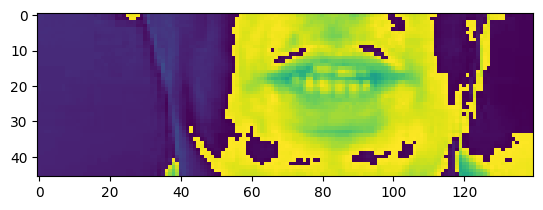

In [26]:
plt.imshow(frames[40])

In [27]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [28]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [29]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
#2. BUILD DATA LOADING FUNCTIONS

In [30]:
from matplotlib import pyplot as plt

In [31]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [32]:
len(test)

50

In [33]:
frames, alignments = data.as_numpy_iterator().next()

Attempting to open: data\alignments\s1\pbai7a.align
Attempting to open: data\alignments\s1\srah4n.align
Attempting to open: data\alignments\s1\pgbe5a.align


In [34]:
len(frames)

2

In [35]:
sample = data.as_numpy_iterator()

In [36]:
val = sample.next(); val[0]

Attempting to open: data\alignments\s1\bbir9a.align
Attempting to open: data\alignments\s1\pgiq2n.align


array([[[[[ 1.4632584 ],
          [ 1.4632584 ],
          [ 1.4632584 ],
          ...,
          [ 9.5496855 ],
          [ 9.434166  ],
          [ 9.434166  ]],

         [[ 1.4632584 ],
          [ 1.4632584 ],
          [ 1.4632584 ],
          ...,
          [ 8.77955   ],
          [ 9.280138  ],
          [ 9.511179  ]],

         [[ 1.3092312 ],
          [ 1.3092312 ],
          [ 1.3092312 ],
          ...,
          [ 9.434166  ],
          [ 0.0385068 ],
          [ 0.0385068 ]],

         ...,

         [[ 1.0011767 ],
          [ 1.0011767 ],
          [ 1.0011767 ],
          ...,
          [ 0.0385068 ],
          [ 9.819234  ],
          [ 9.819234  ]],

         [[ 1.0011767 ],
          [ 1.0011767 ],
          [ 1.0011767 ],
          ...,
          [ 9.780726  ],
          [ 9.780726  ],
          [ 9.780726  ]],

         [[ 1.0011767 ],
          [ 1.0011767 ],
          [ 1.0011767 ],
          ...,
          [ 9.780726  ],
          [ 9.780726  ],
          

Attempting to open: data\alignments\s1\pwwy5a.align
Attempting to open: data\alignments\s1\sgib9s.align


In [37]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.819233894348145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

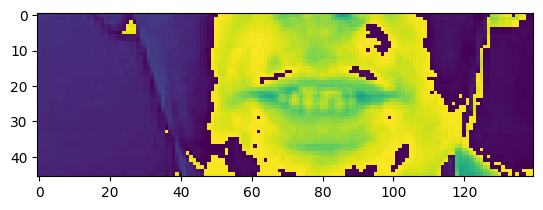

In [38]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [39]:

tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r nine again'>

In [ ]:
#3. DESIGN THE DEEP NUERAL NETWORK

In [128]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Reshape
from keras.layers import TimeDistributed
import tensorflow as tf

In [129]:
data.as_numpy_iterator().next()[0][0].shape

Attempting to open: data\alignments\s1\bginzn.align
Attempting to open: data\alignments\s1\bwat4p.align
Attempting to open: data\alignments\s1\pbbi9s.align


(75, 46, 140, 1)

In [146]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2))) 

model.add(Reshape((75, -1)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [147]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_13 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
5*17*75

6375

In [149]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [150]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'vllllllllllllllllllll9999999999999999999999999999999999999999999llllllllll9'>

In [151]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'vllllllllllllllllllll9999999999999999999999999999999999999999999llllllllll9'>

In [152]:
model.input_shape

(None, 75, 46, 140, 1)

In [153]:
model.output_shape

(None, 75, 41)

In [154]:
#SETUP TRAINING AND OPTIONS

In [155]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [156]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [157]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [160]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [161]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [162]:
schedule_callback = LearningRateScheduler(scheduler)

In [163]:
example_callback = ProduceExample(test)

In [164]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
Attempting to open: data\alignments\s1\swbp1a.align
Attempting to open: data\alignments\s1\bgat9s.align
Attempting to open: data\alignments\s1\lrbr7a.align
Attempting to open: data\alignments\s1\bgia2n.align
Attempting to open: data\alignments\s1\lriq8p.align
Attempting to open: data\alignments\s1\pbav3s.align
Attempting to open: data\alignments\s1\swih9a.align
  1/450 ━━━━━━━━━━━━━━━━━━━━ 1:41:10 14s/step - loss: 238.4678Attempting to open: data\alignments\s1\pwij3s.align
Attempting to open: data\alignments\s1\bris4p.align
Attempting to open: data\alignments\s1\lgil7a.align
  2/450 ━━━━━━━━━━━━━━━━━━━━ 1:35:30 13s/step - loss: 223.6917Attempting to open: data\alignments\s1\lwws7a.align
Attempting to open: data\alignments\s1\lgbg1a.align
  3/450 ━━━━━━━━━━━━━━━━━━━━ 1:35:24 13s/step - loss: 212.9835Attempting to open: data\alignments\s1\pbbc6p.align
Attempting to open: data\alignments\s1\prwd5s.align
  4/450 ━━━━━━━━━━━━━━━━━━━━ 1:34:40 13s/step - loss: 204.5607Attempting t

 41/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:54 13s/step - loss: 142.3941Attempting to open: data\alignments\s1\srwo6n.align
Attempting to open: data\alignments\s1\bbas1s.align
 42/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:45 13s/step - loss: 141.8935Attempting to open: data\alignments\s1\bwwa9s.align
Attempting to open: data\alignments\s1\lrwz2n.align
 43/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:42 13s/step - loss: 141.4048Attempting to open: data\alignments\s1\bwag5s.align
Attempting to open: data\alignments\s1\pgbe2n.align
 44/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:34 13s/step - loss: 140.9286Attempting to open: data\alignments\s1\bwaa2p.align
Attempting to open: data\alignments\s1\bwbt6n.align
 45/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:24 13s/step - loss: 140.4639Attempting to open: data\alignments\s1\bgin3a.align
Attempting to open: data\alignments\s1\bwwn6n.align
 46/450 ━━━━━━━━━━━━━━━━━━━━ 1:26:15 13s/step - loss: 140.0111Attempting to open: data\alignments\s1\pwip9a.align
Attempting to open: data\alignments\s1\lwbszn.align
 47/

 82/450 ━━━━━━━━━━━━━━━━━━━━ 1:19:05 13s/step - loss: 128.6450Attempting to open: data\alignments\s1\lbwe4n.align
Attempting to open: data\alignments\s1\lbby4p.align
 83/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:43 13s/step - loss: 128.4165Attempting to open: data\alignments\s1\pgay3a.align
Attempting to open: data\alignments\s1\pric4p.align
 84/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:21 13s/step - loss: 128.1908Attempting to open: data\alignments\s1\sbig5s.align
Attempting to open: data\alignments\s1\sgwx3s.align
 85/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:02 13s/step - loss: 127.9672Attempting to open: data\alignments\s1\pric2n.align
Attempting to open: data\alignments\s1\bbiz1s.align
 86/450 ━━━━━━━━━━━━━━━━━━━━ 1:17:43 13s/step - loss: 127.7464Attempting to open: data\alignments\s1\swio2p.align
Attempting to open: data\alignments\s1\bgbu5a.align
 87/450 ━━━━━━━━━━━━━━━━━━━━ 1:17:23 13s/step - loss: 127.5285Attempting to open: data\alignments\s1\sgbc9a.align
Attempting to open: data\alignments\s1\srah6p.align
 88/

123/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:47 13s/step - loss: 120.8885Attempting to open: data\alignments\s1\lrik4p.align
Attempting to open: data\alignments\s1\bgbb1s.align
124/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:44 13s/step - loss: 120.7311Attempting to open: data\alignments\s1\bwwu1s.align
Attempting to open: data\alignments\s1\brif7a.align
125/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:37 13s/step - loss: 120.5747Attempting to open: data\alignments\s1\swib2n.align
Attempting to open: data\alignments\s1\lwwm2p.align
126/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:30 13s/step - loss: 120.4194Attempting to open: data\alignments\s1\lrbe6n.align
Attempting to open: data\alignments\s1\pgay1s.align
127/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:23 13s/step - loss: 120.2652Attempting to open: data\alignments\s1\bgwu7s.align
Attempting to open: data\alignments\s1\bril8n.align
128/450 ━━━━━━━━━━━━━━━━━━━━ 1:08:15 13s/step - loss: 120.1121Attempting to open: data\alignments\s1\bbie9s.align
Attempting to open: data\alignments\s1\prac9a.align
129/

164/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:46 14s/step - loss: 115.2970Attempting to open: data\alignments\s1\bgau1a.align
Attempting to open: data\alignments\s1\swwi8n.align
165/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:38 14s/step - loss: 115.1802Attempting to open: data\alignments\s1\pgwr7a.align
Attempting to open: data\alignments\s1\lwiy7s.align
166/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:31 14s/step - loss: 115.0639Attempting to open: data\alignments\s1\sbwu6p.align
Attempting to open: data\alignments\s1\lbaq6p.align
167/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:24 14s/step - loss: 114.9485Attempting to open: data\alignments\s1\brbg2n.align
Attempting to open: data\alignments\s1\sbat9a.align
168/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:16 14s/step - loss: 114.8338Attempting to open: data\alignments\s1\swwp5a.align
Attempting to open: data\alignments\s1\pgwlzn.align
169/450 ━━━━━━━━━━━━━━━━━━━━ 1:04:09 14s/step - loss: 114.7201Attempting to open: data\alignments\s1\pbai7a.align
Attempting to open: data\alignments\s1\lwwz8n.align
170/

205/450 ━━━━━━━━━━━━━━━━━━━━ 54:12 13s/step - loss: 111.0927Attempting to open: data\alignments\s1\pgwy9s.align
Attempting to open: data\alignments\s1\brif5s.align
206/450 ━━━━━━━━━━━━━━━━━━━━ 53:55 13s/step - loss: 111.0028Attempting to open: data\alignments\s1\sbwb5a.align
Attempting to open: data\alignments\s1\bwbt8p.align
207/450 ━━━━━━━━━━━━━━━━━━━━ 53:38 13s/step - loss: 110.9134Attempting to open: data\alignments\s1\sgac2n.align
Attempting to open: data\alignments\s1\lrak9a.align
208/450 ━━━━━━━━━━━━━━━━━━━━ 53:20 13s/step - loss: 110.8245Attempting to open: data\alignments\s1\prax1a.align
Attempting to open: data\alignments\s1\bwim4n.align
209/450 ━━━━━━━━━━━━━━━━━━━━ 53:03 13s/step - loss: 110.7361Attempting to open: data\alignments\s1\pbap1a.align
Attempting to open: data\alignments\s1\sgib9s.align
210/450 ━━━━━━━━━━━━━━━━━━━━ 52:47 13s/step - loss: 110.6485Attempting to open: data\alignments\s1\lwbf3s.align
Attempting to open: data\alignments\s1\lrwl4n.align
211/450 ━━━━━━━━

246/450 ━━━━━━━━━━━━━━━━━━━━ 46:12 14s/step - loss: 107.7861Attempting to open: data\alignments\s1\pbii2p.align
Attempting to open: data\alignments\s1\pbav2n.align
247/450 ━━━━━━━━━━━━━━━━━━━━ 46:01 14s/step - loss: 107.7144Attempting to open: data\alignments\s1\pwbq5s.align
Attempting to open: data\alignments\s1\lrwr9s.align
248/450 ━━━━━━━━━━━━━━━━━━━━ 45:50 14s/step - loss: 107.6431Attempting to open: data\alignments\s1\bbaz5s.align
Attempting to open: data\alignments\s1\swiu7a.align
249/450 ━━━━━━━━━━━━━━━━━━━━ 45:39 14s/step - loss: 107.5721Attempting to open: data\alignments\s1\swbv3s.align
Attempting to open: data\alignments\s1\pwaj9a.align
250/450 ━━━━━━━━━━━━━━━━━━━━ 45:27 14s/step - loss: 107.5014Attempting to open: data\alignments\s1\prac7s.align
Attempting to open: data\alignments\s1\prwq4p.align
251/450 ━━━━━━━━━━━━━━━━━━━━ 45:16 14s/step - loss: 107.4310Attempting to open: data\alignments\s1\lbaq7a.align
Attempting to open: data\alignments\s1\pwwk7a.align
252/450 ━━━━━━━━

287/450 ━━━━━━━━━━━━━━━━━━━━ 37:46 14s/step - loss: 105.0991Attempting to open: data\alignments\s1\sbin1a.align
Attempting to open: data\alignments\s1\bgan4n.align
288/450 ━━━━━━━━━━━━━━━━━━━━ 37:29 14s/step - loss: 105.0395Attempting to open: data\alignments\s1\srah4n.align
Attempting to open: data\alignments\s1\lwwmzn.align
289/450 ━━━━━━━━━━━━━━━━━━━━ 37:12 14s/step - loss: 104.9800Attempting to open: data\alignments\s1\pripzn.align
Attempting to open: data\alignments\s1\bbwt1a.align
290/450 ━━━━━━━━━━━━━━━━━━━━ 36:56 14s/step - loss: 104.9207Attempting to open: data\alignments\s1\pgaq8p.align
Attempting to open: data\alignments\s1\pgaezp.align
291/450 ━━━━━━━━━━━━━━━━━━━━ 36:39 14s/step - loss: 104.8617Attempting to open: data\alignments\s1\lrwr8n.align
Attempting to open: data\alignments\s1\lwal3s.align
292/450 ━━━━━━━━━━━━━━━━━━━━ 36:22 14s/step - loss: 104.8029Attempting to open: data\alignments\s1\bgbu4p.align
Attempting to open: data\alignments\s1\lwbl9a.align
293/450 ━━━━━━━━

328/450 ━━━━━━━━━━━━━━━━━━━━ 27:02 13s/step - loss: 102.8411Attempting to open: data\alignments\s1\pbwj2n.align
Attempting to open: data\alignments\s1\swbi5s.align
329/450 ━━━━━━━━━━━━━━━━━━━━ 26:47 13s/step - loss: 102.7908Attempting to open: data\alignments\s1\swbczn.align
Attempting to open: data\alignments\s1\lbakzn.align
330/450 ━━━━━━━━━━━━━━━━━━━━ 26:33 13s/step - loss: 102.7406Attempting to open: data\alignments\s1\bgig6n.align
Attempting to open: data\alignments\s1\lbax8n.align
331/450 ━━━━━━━━━━━━━━━━━━━━ 26:18 13s/step - loss: 102.6907Attempting to open: data\alignments\s1\sria7s.align
Attempting to open: data\alignments\s1\sraozp.align
332/450 ━━━━━━━━━━━━━━━━━━━━ 26:04 13s/step - loss: 102.6409Attempting to open: data\alignments\s1\sgwj5s.align
Attempting to open: data\alignments\s1\pwad5a.align
333/450 ━━━━━━━━━━━━━━━━━━━━ 25:49 13s/step - loss: 102.5913Attempting to open: data\alignments\s1\pbac2p.align
Attempting to open: data\alignments\s1\lwie4n.align
334/450 ━━━━━━━━

369/450 ━━━━━━━━━━━━━━━━━━━━ 18:08 13s/step - loss: 100.9266Attempting to open: data\alignments\s1\bgwu9a.align
Attempting to open: data\alignments\s1\swao7a.align
370/450 ━━━━━━━━━━━━━━━━━━━━ 17:54 13s/step - loss: 100.8833Attempting to open: data\alignments\s1\sbit5a.align
Attempting to open: data\alignments\s1\lbad7s.align
371/450 ━━━━━━━━━━━━━━━━━━━━ 17:39 13s/step - loss: 100.8402Attempting to open: data\alignments\s1\sban3s.align
Attempting to open: data\alignments\s1\srbo5a.align
372/450 ━━━━━━━━━━━━━━━━━━━━ 17:25 13s/step - loss: 100.7973Attempting to open: data\alignments\s1\pgak3s.align
Attempting to open: data\alignments\s1\bbaz6p.align
373/450 ━━━━━━━━━━━━━━━━━━━━ 17:11 13s/step - loss: 100.7545Attempting to open: data\alignments\s1\srbo4p.align
Attempting to open: data\alignments\s1\prbd2p.align
374/450 ━━━━━━━━━━━━━━━━━━━━ 16:57 13s/step - loss: 100.7118Attempting to open: data\alignments\s1\lwilzp.align
Attempting to open: data\alignments\s1\pbbv6n.align
375/450 ━━━━━━━━

410/450 ━━━━━━━━━━━━━━━━━━━━ 11:59 18s/step - loss: 99.2723Attempting to open: data\alignments\s1\pwbq4n.align
Attempting to open: data\alignments\s1\bris3s.align
411/450 ━━━━━━━━━━━━━━━━━━━━ 11:40 18s/step - loss: 99.2347Attempting to open: data\alignments\s1\pgid6p.align
Attempting to open: data\alignments\s1\lbad9a.align
412/450 ━━━━━━━━━━━━━━━━━━━━ 11:22 18s/step - loss: 99.1973Attempting to open: data\alignments\s1\bras8p.align
Attempting to open: data\alignments\s1\srwo9a.align
413/450 ━━━━━━━━━━━━━━━━━━━━ 14:30 24s/step - loss: 99.1600Attempting to open: data\alignments\s1\bbbmzn.align
Attempting to open: data\alignments\s1\lbid3s.align
414/450 ━━━━━━━━━━━━━━━━━━━━ 14:05 23s/step - loss: 99.1228Attempting to open: data\alignments\s1\prwd4n.align
Attempting to open: data\alignments\s1\lgbm4p.align
415/450 ━━━━━━━━━━━━━━━━━━━━ 13:41 23s/step - loss: 99.0858Attempting to open: data\alignments\s1\lwir3s.align
Attempting to open: data\alignments\s1\sbwh9a.align
416/450 ━━━━━━━━━━━━━━

Attempting to open: data\alignments\s1\lwbl7s.align
Attempting to open: data\alignments\s1\lrbr4n.align
Attempting to open: data\alignments\s1\srwi3s.align
Attempting to open: data\alignments\s1\lriq6n.align
Attempting to open: data\alignments\s1\bgahzn.align
Attempting to open: data\alignments\s1\pbai7a.align
Attempting to open: data\alignments\s1\lwbf2n.align
Attempting to open: data\alignments\s1\lgamzp.align
Attempting to open: data\alignments\s1\swih7s.align
Attempting to open: data\alignments\s1\sgav5s.align
Attempting to open: data\alignments\s1\sbia3a.align
Attempting to open: data\alignments\s1\pwwk7a.align
Attempting to open: data\alignments\s1\pbwc9s.align
Attempting to open: data\alignments\s1\lwafzp.align
Attempting to open: data\alignments\s1\lrwl4n.align
Attempting to open: data\alignments\s1\bbbf6n.align
Attempting to open: data\alignments\s1\srau4p.align
Attempting to open: data\alignments\s1\sbin1a.align
Attempting to open: data\alignments\s1\pgwzzp.align
Attempting t

Attempting to open: data\alignments\s1\lriezp.align
Attempting to open: data\alignments\s1\bbwm6p.align
Attempting to open: data\alignments\s1\lwie4n.align
Attempting to open: data\alignments\s1\pbbc4n.align
Attempting to open: data\alignments\s1\sgbp4n.align
Attempting to open: data\alignments\s1\bbbz8n.align
Attempting to open: data\alignments\s1\sbbu2p.align
Attempting to open: data\alignments\s1\pgiq4p.align
Attempting to open: data\alignments\s1\lwwf9a.align
Attempting to open: data\alignments\s1\sraozp.align
Attempting to open: data\alignments\s1\lgiz3s.align
Attempting to open: data\alignments\s1\pgby7a.align
Attempting to open: data\alignments\s1\lwwmzn.align
Attempting to open: data\alignments\s1\lwar8p.align
Attempting to open: data\alignments\s1\bwbt9a.align
Attempting to open: data\alignments\s1\lwar9a.align
Attempting to open: data\alignments\s1\lwbf5a.align
Attempting to open: data\alignments\s1\swiu4n.align
Attempting to open: data\alignments\s1\srit8n.align
Attempting t

Attempting to open: data\alignments\s1\swiu6p.align
Attempting to open: data\alignments\s1\lgbs6n.align
Attempting to open: data\alignments\s1\pwad4p.align
Attempting to open: data\alignments\s1\pwaq3a.align
Attempting to open: data\alignments\s1\sgbc6n.align
Attempting to open: data\alignments\s1\lbwk8n.align
Attempting to open: data\alignments\s1\brwa5a.align
Attempting to open: data\alignments\s1\bwim6p.align
Attempting to open: data\alignments\s1\bwaa1s.align
Attempting to open: data\alignments\s1\lbid5a.align
Attempting to open: data\alignments\s1\sgiczp.align
Attempting to open: data\alignments\s1\brbm8p.align
Attempting to open: data\alignments\s1\pwbk3a.align
Attempting to open: data\alignments\s1\pwwe3a.align
Attempting to open: data\alignments\s1\swio2p.align
Attempting to open: data\alignments\s1\prac7s.align
Attempting to open: data\alignments\s1\prbd2p.align
Attempting to open: data\alignments\s1\pbiu8n.align
Attempting to open: data\alignments\s1\pwaj9a.align
Attempting t

Attempting to open: data\alignments\s1\srbb4n.align
Attempting to open: data\alignments\s1\lbij6n.align
Attempting to open: data\alignments\s1\bgauzp.align
Attempting to open: data\alignments\s1\lwbs3a.align
Attempting to open: data\alignments\s1\pwij5a.align
Attempting to open: data\alignments\s1\swbi6p.align
Attempting to open: data\alignments\s1\bbie8n.align
Attempting to open: data\alignments\s1\bwbn2n.align
Attempting to open: data\alignments\s1\prii7s.align
Attempting to open: data\alignments\s1\bris5a.align
Attempting to open: data\alignments\s1\lgbs7s.align
Attempting to open: data\alignments\s1\pwbkzn.align
Attempting to open: data\alignments\s1\lgil7a.align
Attempting to open: data\alignments\s1\pbao8n.align
Attempting to open: data\alignments\s1\bgbozp.align
Attempting to open: data\alignments\s1\srab1s.align
Attempting to open: data\alignments\s1\briz6n.align
Attempting to open: data\alignments\s1\pwid1a.align
Attempting to open: data\alignments\s1\bras7s.align
Attempting t

Attempting to open: data\alignments\s1\bgig8p.align
Attempting to open: data\alignments\s1\sran9s.align
Attempting to open: data\alignments\s1\swav1a.align
Attempting to open: data\alignments\s1\prip1s.align
Attempting to open: data\alignments\s1\prii8p.align
Attempting to open: data\alignments\s1\pwip9a.align
Attempting to open: data\alignments\s1\lgbs9a.align
Attempting to open: data\alignments\s1\brwn1s.align
Attempting to open: data\alignments\s1\lbwy7s.align
Attempting to open: data\alignments\s1\sbba8n.align
Attempting to open: data\alignments\s1\srbizp.align
Attempting to open: data\alignments\s1\prbx4p.align
Attempting to open: data\alignments\s1\brbg2n.align
Attempting to open: data\alignments\s1\bris4p.align
Attempting to open: data\alignments\s1\srah7a.align
Attempting to open: data\alignments\s1\bwit1a.align
Attempting to open: data\alignments\s1\lbbq8n.align
Attempting to open: data\alignments\s1\lbax8n.align
Attempting to open: data\alignments\s1\brwg9a.align
Attempting t

Attempting to open: data\alignments\s1\lbwr3s.align
Attempting to open: data\alignments\s1\sban5a.align
Attempting to open: data\alignments\s1\lrwz2n.align
Attempting to open: data\alignments\s1\bbwg3a.align
Attempting to open: data\alignments\s1\pbib9a.align
Attempting to open: data\alignments\s1\pgak5a.align
Attempting to open: data\alignments\s1\pgak4p.align
Attempting to open: data\alignments\s1\pgik1a.align
Attempting to open: data\alignments\s1\pgwl2p.align
Attempting to open: data\alignments\s1\lwiy7s.align
Attempting to open: data\alignments\s1\bbaz6p.align
Attempting to open: data\alignments\s1\pwbq6p.align
Attempting to open: data\alignments\s1\pwad3s.align
Attempting to open: data\alignments\s1\sgiv1s.align
Attempting to open: data\alignments\s1\lgaz6n.align
Attempting to open: data\alignments\s1\bgaa9a.align
Attempting to open: data\alignments\s1\lbix6p.align
Attempting to open: data\alignments\s1\lbij7s.align
Attempting to open: data\alignments\s1\pgwlzn.align
Attempting t

Attempting to open: data\alignments\s1\pbiu9s.align
Attempting to open: data\alignments\s1\bwba5s.align
Attempting to open: data\alignments\s1\bbbf8p.align
Attempting to open: data\alignments\s1\bgbu2n.align
Attempting to open: data\alignments\s1\swbc2p.align
Attempting to open: data\alignments\s1\lbbe1s.align
Attempting to open: data\alignments\s1\sbwu7a.align
Attempting to open: data\alignments\s1\bbws8n.align
Attempting to open: data\alignments\s1\pwaq2p.align
Attempting to open: data\alignments\s1\brwg8p.align
Attempting to open: data\alignments\s1\bgwo5a.align
Attempting to open: data\alignments\s1\lbwe7a.align
Attempting to open: data\alignments\s1\brbm6n.align
Attempting to open: data\alignments\s1\bbal9a.align
Attempting to open: data\alignments\s1\bwwa8n.align
Attempting to open: data\alignments\s1\bwat4p.align
Attempting to open: data\alignments\s1\pbav5a.align
Attempting to open: data\alignments\s1\lrak8p.align
Attempting to open: data\alignments\s1\brwg7s.align
Attempting t

Attempting to open: data\alignments\s1\lwwz8n.align
Attempting to open: data\alignments\s1\pwip8p.align
Attempting to open: data\alignments\s1\sgbj1s.align
Attempting to open: data\alignments\s1\bwwn9a.align
Attempting to open: data\alignments\s1\bwwn6n.align
Attempting to open: data\alignments\s1\lgwm8p.align
Attempting to open: data\alignments\s1\sbbu2p.align
Attempting to open: data\alignments\s1\bras8p.align
Attempting to open: data\alignments\s1\bbizzn.align
Attempting to open: data\alignments\s1\pbbc7a.align
Attempting to open: data\alignments\s1\sriu1a.align
Attempting to open: data\alignments\s1\lwar6n.align
Attempting to open: data\alignments\s1\lwbf4p.align
Attempting to open: data\alignments\s1\bbbs4n.align
Attempting to open: data\alignments\s1\sgio6n.align
Attempting to open: data\alignments\s1\sgib8n.align
Attempting to open: data\alignments\s1\sgwx2n.align
Attempting to open: data\alignments\s1\swiu7a.align
Attempting to open: data\alignments\s1\pgid5s.align
Attempting t

Attempting to open: data\alignments\s1\bbiz1s.align
Attempting to open: data\alignments\s1\lrak9a.align
Attempting to open: data\alignments\s1\lgil7a.align
Attempting to open: data\alignments\s1\lbad9a.align
Attempting to open: data\alignments\s1\lbwe7a.align
Attempting to open: data\alignments\s1\pwaj8p.align
Attempting to open: data\alignments\s1\bbie9s.align
Attempting to open: data\alignments\s1\pgwr7a.align
Attempting to open: data\alignments\s1\brwa3s.align
Attempting to open: data\alignments\s1\lwbs2p.align
Attempting to open: data\alignments\s1\srbo4p.align
Attempting to open: data\alignments\s1\sgio7s.align
Attempting to open: data\alignments\s1\pwid1a.align
Attempting to open: data\alignments\s1\lbwy9a.align
Attempting to open: data\alignments\s1\pgid6p.align
Attempting to open: data\alignments\s1\bwat4p.align
Attempting to open: data\alignments\s1\swwi9s.align
Attempting to open: data\alignments\s1\sbig7a.align
Attempting to open: data\alignments\s1\bwig2p.align
Attempting t

Attempting to open: data\alignments\s1\pwwrzp.align
Attempting to open: data\alignments\s1\bram4p.align
Attempting to open: data\alignments\s1\pbwp7s.align
Attempting to open: data\alignments\s1\bgwh8n.align
Attempting to open: data\alignments\s1\pgaezp.align
Attempting to open: data\alignments\s1\lgbs7s.align
Attempting to open: data\alignments\s1\prwj9s.align
Attempting to open: data\alignments\s1\lbbq8n.align
Attempting to open: data\alignments\s1\bgwu9a.align
Attempting to open: data\alignments\s1\bwat5a.align
Attempting to open: data\alignments\s1\prac8p.align
Attempting to open: data\alignments\s1\pwip7s.align
Attempting to open: data\alignments\s1\lgil4n.align
Attempting to open: data\alignments\s1\srihzn.align
Attempting to open: data\alignments\s1\lbwy8p.align
Attempting to open: data\alignments\s1\pgwr5s.align
Attempting to open: data\alignments\s1\sgwd3a.align
Attempting to open: data\alignments\s1\pwax5s.align
Attempting to open: data\alignments\s1\lrik5a.align
Attempting t

Attempting to open: data\alignments\s1\lwwm1s.align
Attempting to open: data\alignments\s1\brwt4n.align
Attempting to open: data\alignments\s1\bgwu7s.align
Attempting to open: data\alignments\s1\lbwy6n.align
Attempting to open: data\alignments\s1\bbwtzp.align
Attempting to open: data\alignments\s1\brbg5a.align
Attempting to open: data\alignments\s1\lwal4p.align
Attempting to open: data\alignments\s1\bbaf2n.align
Attempting to open: data\alignments\s1\bwbn4p.align
Attempting to open: data\alignments\s1\bgit4n.align
Attempting to open: data\alignments\s1\sbia1s.align
Attempting to open: data\alignments\s1\brbazp.align
Attempting to open: data\alignments\s1\srbu7s.align
Attempting to open: data\alignments\s1\brwa4p.align
Attempting to open: data\alignments\s1\bwan1a.align
Attempting to open: data\alignments\s1\pbiu8n.align
Attempting to open: data\alignments\s1\swab9a.align
Attempting to open: data\alignments\s1\pgayzn.align
Attempting to open: data\alignments\s1\sbwh9a.align
Attempting t

Attempting to open: data\alignments\s1\pbbc6p.align
Attempting to open: data\alignments\s1\lwbf3s.align
Attempting to open: data\alignments\s1\sria6n.align
Attempting to open: data\alignments\s1\lgwt2p.align
Attempting to open: data\alignments\s1\bwig1s.align
Attempting to open: data\alignments\s1\lriyzn.align
Attempting to open: data\alignments\s1\sgap1s.align
Attempting to open: data\alignments\s1\brbm7s.align
Attempting to open: data\alignments\s1\sgic1a.align
Attempting to open: data\alignments\s1\lwwf8p.align
Attempting to open: data\alignments\s1\sgwj5s.align
Attempting to open: data\alignments\s1\sgio8p.align
Attempting to open: data\alignments\s1\bgbh5s.align
Attempting to open: data\alignments\s1\brbtzn.align
Attempting to open: data\alignments\s1\brwnzn.align
Attempting to open: data\alignments\s1\pbio4n.align
Attempting to open: data\alignments\s1\bbir9a.align
Attempting to open: data\alignments\s1\bgbu4p.align
Attempting to open: data\alignments\s1\lwae9s.align
Attempting t

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Original: set red at u five again
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by a one again
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 10717s 24s/step - loss: 97.8262 - val_loss: 69.6039 - learning_rate: 1.0000e-04
Epoch 2/100
Attempting to open: data\alignments\s1\lwilzp.align
Attempting to open: data\alignments\s1\pgiq2n.align
Attempting to open: data\alignments\s1\bgan7a.align
Attempting to open: data\alignments\s1\pwwe2p.align
Attempting to open: data\alignments\s1\sgbv8n.align
Attempting to open: data\alignments\s1\bril9s.align
Attempting to open: data\alignments\s1\swao5s.align
Attempting to open: data\alignments\s1\brwn1s.align
Attempting to open: data\alignments\s1\bgwu7s.align
Attempting to open: data\alignments\s1\sgwj4n.align
  1/

 37/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:00 13s/step - loss: 73.9867Attempting to open: data\alignments\s1\bbbm1s.align
Attempting to open: data\alignments\s1\bbizzn.align
 38/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:01 13s/step - loss: 73.9826Attempting to open: data\alignments\s1\sbaa5s.align
Attempting to open: data\alignments\s1\srwvzn.align
 39/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:08 13s/step - loss: 73.9763Attempting to open: data\alignments\s1\bbwm4n.align
Attempting to open: data\alignments\s1\brwa2n.align
 40/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:24 13s/step - loss: 73.9672Attempting to open: data\alignments\s1\pgikzp.align
Attempting to open: data\alignments\s1\bbal9a.align
 41/450 ━━━━━━━━━━━━━━━━━━━━ 1:59:17 18s/step - loss: 73.9567Attempting to open: data\alignments\s1\sbwh9a.align
Attempting to open: data\alignments\s1\sgbp6p.align
 42/450 ━━━━━━━━━━━━━━━━━━━━ 1:58:09 17s/step - loss: 73.9429Attempting to open: data\alignments\s1\bris5a.align
Attempting to open: data\alignments\s1\sbwb5a.align
 43/450 ━━

 78/450 ━━━━━━━━━━━━━━━━━━━━ 1:36:15 16s/step - loss: 73.6222Attempting to open: data\alignments\s1\sgio8p.align
Attempting to open: data\alignments\s1\pwad3s.align
 79/450 ━━━━━━━━━━━━━━━━━━━━ 1:35:48 15s/step - loss: 73.6117Attempting to open: data\alignments\s1\pgiq5a.align
Attempting to open: data\alignments\s1\bwaazn.align
 80/450 ━━━━━━━━━━━━━━━━━━━━ 1:35:21 15s/step - loss: 73.6009Attempting to open: data\alignments\s1\lbby4p.align
Attempting to open: data\alignments\s1\lbaq7a.align
 81/450 ━━━━━━━━━━━━━━━━━━━━ 1:34:55 15s/step - loss: 73.5916Attempting to open: data\alignments\s1\lwwz8n.align
Attempting to open: data\alignments\s1\lgbm3s.align
 82/450 ━━━━━━━━━━━━━━━━━━━━ 1:34:28 15s/step - loss: 73.5832Attempting to open: data\alignments\s1\lgil6p.align
Attempting to open: data\alignments\s1\bwaa2p.align
 83/450 ━━━━━━━━━━━━━━━━━━━━ 1:34:03 15s/step - loss: 73.5746Attempting to open: data\alignments\s1\lgiz2n.align
Attempting to open: data\alignments\s1\lwal5a.align
 84/450 ━━

119/450 ━━━━━━━━━━━━━━━━━━━━ 1:30:00 16s/step - loss: 73.2745Attempting to open: data\alignments\s1\bgit7a.align
Attempting to open: data\alignments\s1\swwv8p.align
120/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:35 16s/step - loss: 73.2673Attempting to open: data\alignments\s1\pbai6p.align
Attempting to open: data\alignments\s1\swwp5a.align
121/450 ━━━━━━━━━━━━━━━━━━━━ 1:29:10 16s/step - loss: 73.2603Attempting to open: data\alignments\s1\sgap1s.align
Attempting to open: data\alignments\s1\pgby4n.align
122/450 ━━━━━━━━━━━━━━━━━━━━ 1:28:45 16s/step - loss: 73.2532Attempting to open: data\alignments\s1\sbin1a.align
Attempting to open: data\alignments\s1\lrbe6n.align
123/450 ━━━━━━━━━━━━━━━━━━━━ 1:28:20 16s/step - loss: 73.2464Attempting to open: data\alignments\s1\lbwy8p.align
Attempting to open: data\alignments\s1\bgan7a.align
124/450 ━━━━━━━━━━━━━━━━━━━━ 1:27:55 16s/step - loss: 73.2402Attempting to open: data\alignments\s1\sgiv1s.align
Attempting to open: data\alignments\s1\lbad6n.align
125/450 ━━

160/450 ━━━━━━━━━━━━━━━━━━━━ 1:19:06 16s/step - loss: 73.0427Attempting to open: data\alignments\s1\swih8p.align
Attempting to open: data\alignments\s1\lwie4n.align
161/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:44 16s/step - loss: 73.0393Attempting to open: data\alignments\s1\prwj8n.align
Attempting to open: data\alignments\s1\lwal2n.align
162/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:21 16s/step - loss: 73.0357Attempting to open: data\alignments\s1\bgit5s.align
Attempting to open: data\alignments\s1\bgit6p.align
163/450 ━━━━━━━━━━━━━━━━━━━━ 1:18:00 16s/step - loss: 73.0321Attempting to open: data\alignments\s1\pbbi8n.align
Attempting to open: data\alignments\s1\lgifzn.align
164/450 ━━━━━━━━━━━━━━━━━━━━ 1:17:38 16s/step - loss: 73.0286Attempting to open: data\alignments\s1\pgix8p.align
Attempting to open: data\alignments\s1\srwv2p.align
165/450 ━━━━━━━━━━━━━━━━━━━━ 1:17:19 16s/step - loss: 73.0250Attempting to open: data\alignments\s1\lwae9s.align
Attempting to open: data\alignments\s1\lray6p.align
166/450 ━━

201/450 ━━━━━━━━━━━━━━━━━━━━ 1:07:11 16s/step - loss: 72.9051Attempting to open: data\alignments\s1\lwbl9a.align
Attempting to open: data\alignments\s1\lrbr7a.align
202/450 ━━━━━━━━━━━━━━━━━━━━ 1:06:52 16s/step - loss: 72.9021Attempting to open: data\alignments\s1\pgad9s.align
Attempting to open: data\alignments\s1\lbbq8n.align
203/450 ━━━━━━━━━━━━━━━━━━━━ 1:06:34 16s/step - loss: 72.8992Attempting to open: data\alignments\s1\lrby9s.align
Attempting to open: data\alignments\s1\lgwm9a.align
204/450 ━━━━━━━━━━━━━━━━━━━━ 1:06:16 16s/step - loss: 72.8961Attempting to open: data\alignments\s1\bwba4n.align
Attempting to open: data\alignments\s1\prwj9s.align
205/450 ━━━━━━━━━━━━━━━━━━━━ 1:05:57 16s/step - loss: 72.8930Attempting to open: data\alignments\s1\swbpzp.align
Attempting to open: data\alignments\s1\pbwxzn.align
206/450 ━━━━━━━━━━━━━━━━━━━━ 1:05:39 16s/step - loss: 72.8898Attempting to open: data\alignments\s1\bbaszn.align
Attempting to open: data\alignments\s1\bgat9s.align
207/450 ━━

242/450 ━━━━━━━━━━━━━━━━━━━━ 55:41 16s/step - loss: 72.7715Attempting to open: data\alignments\s1\bgbh6p.align
Attempting to open: data\alignments\s1\sgai7s.align
243/450 ━━━━━━━━━━━━━━━━━━━━ 55:24 16s/step - loss: 72.7679Attempting to open: data\alignments\s1\srah5s.align
Attempting to open: data\alignments\s1\pbbp3s.align
244/450 ━━━━━━━━━━━━━━━━━━━━ 55:07 16s/step - loss: 72.7645Attempting to open: data\alignments\s1\srau2n.align
Attempting to open: data\alignments\s1\lbwr2n.align
245/450 ━━━━━━━━━━━━━━━━━━━━ 54:50 16s/step - loss: 72.7609Attempting to open: data\alignments\s1\lray5s.align
Attempting to open: data\alignments\s1\lgamzp.align
246/450 ━━━━━━━━━━━━━━━━━━━━ 54:33 16s/step - loss: 72.7574Attempting to open: data\alignments\s1\sgbc9a.align
Attempting to open: data\alignments\s1\bbal7s.align
247/450 ━━━━━━━━━━━━━━━━━━━━ 54:16 16s/step - loss: 72.7538Attempting to open: data\alignments\s1\bbbz9s.align
Attempting to open: data\alignments\s1\sbinzp.align
248/450 ━━━━━━━━━━━━━━

Attempting to open: data\alignments\s1\bwwh2n.align
284/450 ━━━━━━━━━━━━━━━━━━━━ 44:25 16s/step - loss: 72.6306Attempting to open: data\alignments\s1\lwiy7s.align
Attempting to open: data\alignments\s1\brbtzn.align
285/450 ━━━━━━━━━━━━━━━━━━━━ 44:09 16s/step - loss: 72.6279Attempting to open: data\alignments\s1\lriy3a.align
Attempting to open: data\alignments\s1\lbax8n.align
286/450 ━━━━━━━━━━━━━━━━━━━━ 43:52 16s/step - loss: 72.6253Attempting to open: data\alignments\s1\prbj5s.align
Attempting to open: data\alignments\s1\lwar7s.align
287/450 ━━━━━━━━━━━━━━━━━━━━ 43:35 16s/step - loss: 72.6227Attempting to open: data\alignments\s1\bwwb1a.align
Attempting to open: data\alignments\s1\bgbn9s.align
288/450 ━━━━━━━━━━━━━━━━━━━━ 43:17 16s/step - loss: 72.6202Attempting to open: data\alignments\s1\srwo9a.align
Attempting to open: data\alignments\s1\pbio4n.align
289/450 ━━━━━━━━━━━━━━━━━━━━ 43:00 16s/step - loss: 72.6178Attempting to open: data\alignments\s1\srbi1a.align
Attempting to open: da

325/450 ━━━━━━━━━━━━━━━━━━━━ 33:10 16s/step - loss: 72.5264Attempting to open: data\alignments\s1\sgio6n.align
Attempting to open: data\alignments\s1\brbt2p.align
326/450 ━━━━━━━━━━━━━━━━━━━━ 32:53 16s/step - loss: 72.5240Attempting to open: data\alignments\s1\bwam8n.align
Attempting to open: data\alignments\s1\priv6p.align
327/450 ━━━━━━━━━━━━━━━━━━━━ 32:37 16s/step - loss: 72.5215Attempting to open: data\alignments\s1\lbwk8n.align
Attempting to open: data\alignments\s1\pbapzp.align
328/450 ━━━━━━━━━━━━━━━━━━━━ 32:21 16s/step - loss: 72.5190Attempting to open: data\alignments\s1\lbayzp.align
Attempting to open: data\alignments\s1\sgic1a.align
329/450 ━━━━━━━━━━━━━━━━━━━━ 32:04 16s/step - loss: 72.5165Attempting to open: data\alignments\s1\sgwx4p.align
Attempting to open: data\alignments\s1\brbg4p.align
330/450 ━━━━━━━━━━━━━━━━━━━━ 31:49 16s/step - loss: 72.5139Attempting to open: data\alignments\s1\lbid4p.align
Attempting to open: data\alignments\s1\sbba9s.align
331/450 ━━━━━━━━━━━━━━

Attempting to open: data\alignments\s1\pwbkzn.align
367/450 ━━━━━━━━━━━━━━━━━━━━ 22:00 16s/step - loss: 72.4214Attempting to open: data\alignments\s1\lbij8p.align
Attempting to open: data\alignments\s1\sgii2n.align
368/450 ━━━━━━━━━━━━━━━━━━━━ 21:44 16s/step - loss: 72.4188Attempting to open: data\alignments\s1\pwwe1s.align
Attempting to open: data\alignments\s1\sbat9a.align
369/450 ━━━━━━━━━━━━━━━━━━━━ 21:28 16s/step - loss: 72.4163Attempting to open: data\alignments\s1\lbwlzp.align
Attempting to open: data\alignments\s1\sbwo1s.align
370/450 ━━━━━━━━━━━━━━━━━━━━ 21:12 16s/step - loss: 72.4137Attempting to open: data\alignments\s1\sbbu3a.align
Attempting to open: data\alignments\s1\bgwb7a.align
371/450 ━━━━━━━━━━━━━━━━━━━━ 20:56 16s/step - loss: 72.4111Attempting to open: data\alignments\s1\lwar8p.align
Attempting to open: data\alignments\s1\brwa3s.align
372/450 ━━━━━━━━━━━━━━━━━━━━ 20:40 16s/step - loss: 72.4085Attempting to open: data\alignments\s1\pbib7s.align
Attempting to open: da

408/450 ━━━━━━━━━━━━━━━━━━━━ 10:57 16s/step - loss: 72.3156Attempting to open: data\alignments\s1\lbakzn.align
Attempting to open: data\alignments\s1\lwaf1a.align
409/450 ━━━━━━━━━━━━━━━━━━━━ 10:41 16s/step - loss: 72.3130Attempting to open: data\alignments\s1\bbal6n.align
Attempting to open: data\alignments\s1\sgio7s.align
410/450 ━━━━━━━━━━━━━━━━━━━━ 10:25 16s/step - loss: 72.3105Attempting to open: data\alignments\s1\lgwg3s.align
Attempting to open: data\alignments\s1\bbir6n.align
411/450 ━━━━━━━━━━━━━━━━━━━━ 10:09 16s/step - loss: 72.3080Attempting to open: data\alignments\s1\swbi7a.align
Attempting to open: data\alignments\s1\srabzn.align
412/450 ━━━━━━━━━━━━━━━━━━━━ 9:53 16s/step - loss: 72.3054 Attempting to open: data\alignments\s1\pwwq9s.align
Attempting to open: data\alignments\s1\sgbc8p.align
413/450 ━━━━━━━━━━━━━━━━━━━━ 9:37 16s/step - loss: 72.3029Attempting to open: data\alignments\s1\srbb6p.align
Attempting to open: data\alignments\s1\lrwl6p.align
414/450 ━━━━━━━━━━━━━━━

Attempting to open: data\alignments\s1\pgik1a.align
Attempting to open: data\alignments\s1\lbid4p.align
Attempting to open: data\alignments\s1\srit9s.align
Attempting to open: data\alignments\s1\swbc2p.align
Attempting to open: data\alignments\s1\brwa3s.align
Attempting to open: data\alignments\s1\srab3a.align
Attempting to open: data\alignments\s1\brwt5s.align
Attempting to open: data\alignments\s1\lbwy8p.align
Attempting to open: data\alignments\s1\sgbp4n.align
Attempting to open: data\alignments\s1\swav1a.align
Attempting to open: data\alignments\s1\srwo9a.align
Attempting to open: data\alignments\s1\sgav4n.align
Attempting to open: data\alignments\s1\swwv8p.align
Attempting to open: data\alignments\s1\brwg8p.align
Attempting to open: data\alignments\s1\bwbn4p.align
Attempting to open: data\alignments\s1\sbat8p.align
Attempting to open: data\alignments\s1\pgwr4n.align
Attempting to open: data\alignments\s1\bwbt7s.align
Attempting to open: data\alignments\s1\lrae2n.align
Attempting t

Attempting to open: data\alignments\s1\lbwe5s.align
Attempting to open: data\alignments\s1\brbg5a.align
Attempting to open: data\alignments\s1\prac7s.align
Attempting to open: data\alignments\s1\pbio7a.align
Attempting to open: data\alignments\s1\pbii2p.align
Attempting to open: data\alignments\s1\bgin1s.align
Attempting to open: data\alignments\s1\pgaq7s.align
Attempting to open: data\alignments\s1\swab9a.align
Attempting to open: data\alignments\s1\lwbs1s.align
Attempting to open: data\alignments\s1\sgwx2n.align
Attempting to open: data\alignments\s1\pwbd6n.align
Attempting to open: data\alignments\s1\srwv1s.align
Attempting to open: data\alignments\s1\swao7a.align
Attempting to open: data\alignments\s1\pgikzp.align
Attempting to open: data\alignments\s1\pwbx8n.align
Attempting to open: data\alignments\s1\pbio6p.align
Attempting to open: data\alignments\s1\bwim7a.align
Attempting to open: data\alignments\s1\brbm8p.align
Attempting to open: data\alignments\s1\lrwz3s.align
Attempting t

Attempting to open: data\alignments\s1\pbiu8n.align
Attempting to open: data\alignments\s1\lbax8n.align
Attempting to open: data\alignments\s1\pgiq5a.align
Attempting to open: data\alignments\s1\bwat4p.align
Attempting to open: data\alignments\s1\swbi4n.align
Attempting to open: data\alignments\s1\srwi4p.align
Attempting to open: data\alignments\s1\lgbs8p.align
Attempting to open: data\alignments\s1\swwc6p.align
Attempting to open: data\alignments\s1\srwczp.align
Attempting to open: data\alignments\s1\bwwa9s.align
Attempting to open: data\alignments\s1\lgbm5a.align
Attempting to open: data\alignments\s1\bwaazn.align
Attempting to open: data\alignments\s1\lbby4p.align
Attempting to open: data\alignments\s1\prwq2n.align
Attempting to open: data\alignments\s1\srbh8n.align
Attempting to open: data\alignments\s1\pric3s.align
Attempting to open: data\alignments\s1\swib2n.align
Attempting to open: data\alignments\s1\lgwazp.align
Attempting to open: data\alignments\s1\swbc1s.align
Attempting t

Attempting to open: data\alignments\s1\sban2n.align
Attempting to open: data\alignments\s1\lwie4n.align
Attempting to open: data\alignments\s1\lwik8n.align
Attempting to open: data\alignments\s1\pgbe5a.align
Attempting to open: data\alignments\s1\pwax6p.align
Attempting to open: data\alignments\s1\lbwy7s.align
Attempting to open: data\alignments\s1\lwbf3s.align
Attempting to open: data\alignments\s1\lrwfzn.align
Attempting to open: data\alignments\s1\sgwx3s.align
Attempting to open: data\alignments\s1\pwip8p.align
Attempting to open: data\alignments\s1\pgwe9a.align
Attempting to open: data\alignments\s1\pwbyzp.align
Attempting to open: data\alignments\s1\lgaf4n.align
Attempting to open: data\alignments\s1\sgav5s.align
Attempting to open: data\alignments\s1\sgac2n.align
Attempting to open: data\alignments\s1\bbal8p.align
Attempting to open: data\alignments\s1\sgbp5s.align
Attempting to open: data\alignments\s1\swbc3a.align
Attempting to open: data\alignments\s1\bwwh2n.align
Attempting t

Attempting to open: data\alignments\s1\lwbz4n.align
Attempting to open: data\alignments\s1\bbil3s.align
Attempting to open: data\alignments\s1\pgid4n.align
Attempting to open: data\alignments\s1\sbwb2n.align
Attempting to open: data\alignments\s1\sbba8n.align
Attempting to open: data\alignments\s1\prap4n.align
Attempting to open: data\alignments\s1\sgio9a.align
Attempting to open: data\alignments\s1\swwj1a.align
Attempting to open: data\alignments\s1\pbbp3s.align
Attempting to open: data\alignments\s1\swio3a.align
Attempting to open: data\alignments\s1\sgivzn.align
Attempting to open: data\alignments\s1\sbinzp.align
Attempting to open: data\alignments\s1\bgig8p.align
Attempting to open: data\alignments\s1\pbap1a.align
Attempting to open: data\alignments\s1\lbaq6p.align
Attempting to open: data\alignments\s1\pbwc9s.align
Attempting to open: data\alignments\s1\prwkzp.align
Attempting to open: data\alignments\s1\prap7a.align
Attempting to open: data\alignments\s1\bgan4n.align
Attempting t

Attempting to open: data\alignments\s1\lrby8n.align
Attempting to open: data\alignments\s1\lgwtzn.align
Attempting to open: data\alignments\s1\sbwh6n.align
Attempting to open: data\alignments\s1\pbbv7s.align
Attempting to open: data\alignments\s1\pbwp7s.align
Attempting to open: data\alignments\s1\pwaj7s.align
Attempting to open: data\alignments\s1\briz6n.align
Attempting to open: data\alignments\s1\pgix7s.align
Attempting to open: data\alignments\s1\sgac3s.align
Attempting to open: data\alignments\s1\pwip9a.align
Attempting to open: data\alignments\s1\prii9a.align
Attempting to open: data\alignments\s1\pgaq9a.align
Attempting to open: data\alignments\s1\lbaq4n.align
Attempting to open: data\alignments\s1\bwis8n.align
Attempting to open: data\alignments\s1\lgamzp.align
Attempting to open: data\alignments\s1\pwbq5s.align
Attempting to open: data\alignments\s1\lrbe9a.align
Attempting to open: data\alignments\s1\swao4n.align
Attempting to open: data\alignments\s1\bbbs7a.align
Attempting t

Attempting to open: data\alignments\s1\bgah3a.align
Attempting to open: data\alignments\s1\bgat9s.align
Attempting to open: data\alignments\s1\bbir6n.align
Attempting to open: data\alignments\s1\bgin3a.align
Attempting to open: data\alignments\s1\lbbq9s.align
Attempting to open: data\alignments\s1\prwd4n.align
Attempting to open: data\alignments\s1\lrwr8n.align
Attempting to open: data\alignments\s1\swau8n.align
Attempting to open: data\alignments\s1\bgbh7a.align
Attempting to open: data\alignments\s1\swwv6n.align
Attempting to open: data\alignments\s1\lbax9s.align
Attempting to open: data\alignments\s1\lwar8p.align
Attempting to open: data\alignments\s1\bbifzp.align
Attempting to open: data\alignments\s1\bwim4n.align
Attempting to open: data\alignments\s1\sgwd3a.align
Attempting to open: data\alignments\s1\bwig2p.align
Attempting to open: data\alignments\s1\bbil4p.align
Attempting to open: data\alignments\s1\lwaz3a.align
Attempting to open: data\alignments\s1\pgbr3a.align
Attempting t

KeyboardInterrupt: 

In [ ]:
#5. MAKE A PREDICTION

In [165]:

url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3da69993-1fe6-4d01-ac0e-657268022a9b
To: C:\Users\patel\Documents\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:15<00:00, 6.29MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [175]:

model.load_weights('models/checkpoint.weights.h5')

In [176]:
test_data = test.as_numpy_iterator()

In [177]:
sample = test_data.next()

Attempting to open: data\alignments\s1\lgbg1a.align
Attempting to open: data\alignments\s1\sbat6n.align
Attempting to open: data\alignments\s1\pgaq6n.align
Attempting to open: data\alignments\s1\pric2n.align
Attempting to open: data\alignments\s1\bbir8p.align
Attempting to open: data\alignments\s1\pgbe4p.align
Attempting to open: data\alignments\s1\sbat8p.align
Attempting to open: data\alignments\s1\bbal6n.align
Attempting to open: data\alignments\s1\sbbn6n.align
Attempting to open: data\alignments\s1\srwb8n.align
Attempting to open: data\alignments\s1\lgiz5a.align
Attempting to open: data\alignments\s1\pgik1a.align
Attempting to open: data\alignments\s1\srit8n.align
Attempting to open: data\alignments\s1\bgbu2n.align
Attempting to open: data\alignments\s1\pgae1a.align
Attempting to open: data\alignments\s1\pbib6n.align
Attempting to open: data\alignments\s1\sban3s.align
Attempting to open: data\alignments\s1\lbwr4p.align
Attempting to open: data\alignments\s1\bgia5a.align
Attempting t

Attempting to open: data\alignments\s1\sbat7s.align
Attempting to open: data\alignments\s1\sbit3s.align
Attempting to open: data\alignments\s1\sbwb2n.align
Attempting to open: data\alignments\s1\prwx6n.align
Attempting to open: data\alignments\s1\bbbz9s.align
Attempting to open: data\alignments\s1\pbbp2n.align
Attempting to open: data\alignments\s1\prwx8p.align
Attempting to open: data\alignments\s1\sbag9s.align
Attempting to open: data\alignments\s1\pgwl1s.align
Attempting to open: data\alignments\s1\bgwo3s.align
Attempting to open: data\alignments\s1\lgil5s.align
Attempting to open: data\alignments\s1\lrik2n.align
Attempting to open: data\alignments\s1\srwvzn.align
Attempting to open: data\alignments\s1\pbwj2n.align
Attempting to open: data\alignments\s1\sbinzp.align
Attempting to open: data\alignments\s1\lrwl6p.align
Attempting to open: data\alignments\s1\bwam9s.align
Attempting to open: data\alignments\s1\prbp8n.align
Attempting to open: data\alignments\s1\lbix5s.align
Attempting t

Attempting to open: data\alignments\s1\lwal5a.align
Attempting to open: data\alignments\s1\pbbv8p.align
Attempting to open: data\alignments\s1\sbia2p.align
Attempting to open: data\alignments\s1\lrak7s.align
Attempting to open: data\alignments\s1\bwwh2n.align
Attempting to open: data\alignments\s1\srbo4p.align
Attempting to open: data\alignments\s1\pbiv1a.align
Attempting to open: data\alignments\s1\prbj5s.align
Attempting to open: data\alignments\s1\pgbrzn.align
Attempting to open: data\alignments\s1\priv4n.align
Attempting to open: data\alignments\s1\sbaa5s.align
Attempting to open: data\alignments\s1\swio3a.align
Attempting to open: data\alignments\s1\pwbq4n.align
Attempting to open: data\alignments\s1\bbaf2n.align
Attempting to open: data\alignments\s1\pbwx2p.align
Attempting to open: data\alignments\s1\lriezp.align
Attempting to open: data\alignments\s1\pbao8n.align
Attempting to open: data\alignments\s1\pbbp5a.align
Attempting to open: data\alignments\s1\lbbe2p.align
Attempting t

Attempting to open: data\alignments\s1\lgaf6p.align
Attempting to open: data\alignments\s1\bgwo5a.align
Attempting to open: data\alignments\s1\lbad6n.align
Attempting to open: data\alignments\s1\sgbj1s.align
Attempting to open: data\alignments\s1\pwwe2p.align
Attempting to open: data\alignments\s1\brwnzn.align
Attempting to open: data\alignments\s1\lrbr6p.align
Attempting to open: data\alignments\s1\brwg6n.align
Attempting to open: data\alignments\s1\pgaq9a.align
Attempting to open: data\alignments\s1\bgwb6p.align
Attempting to open: data\alignments\s1\pwbd7s.align
Attempting to open: data\alignments\s1\lbby3s.align
Attempting to open: data\alignments\s1\pgwlzn.align
Attempting to open: data\alignments\s1\lwbz5s.align
Attempting to open: data\alignments\s1\lbwr2n.align
Attempting to open: data\alignments\s1\lbwe5s.align
Attempting to open: data\alignments\s1\pbwp6n.align
Attempting to open: data\alignments\s1\pbio6p.align
Attempting to open: data\alignments\s1\brif6p.align
Attempting t

Attempting to open: data\alignments\s1\pbiu9s.align
Attempting to open: data\alignments\s1\lgif2p.align
Attempting to open: data\alignments\s1\swbi6p.align
Attempting to open: data\alignments\s1\bgbb1s.align
Attempting to open: data\alignments\s1\bgwi1a.align
Attempting to open: data\alignments\s1\bwim6p.align
Attempting to open: data\alignments\s1\bgaa7s.align
Attempting to open: data\alignments\s1\srwi2n.align
Attempting to open: data\alignments\s1\prbqzp.align
Attempting to open: data\alignments\s1\prbx2n.align
Attempting to open: data\alignments\s1\swwi8n.align
Attempting to open: data\alignments\s1\brif7a.align
Attempting to open: data\alignments\s1\lbid5a.align
Attempting to open: data\alignments\s1\sbwo1s.align
Attempting to open: data\alignments\s1\lray6p.align
Attempting to open: data\alignments\s1\srbb6p.align
Attempting to open: data\alignments\s1\bwbg9s.align
Attempting to open: data\alignments\s1\pgwe8p.align
Attempting to open: data\alignments\s1\bgbb3a.align
Attempting t

Attempting to open: data\alignments\s1\lgil6p.align
Attempting to open: data\alignments\s1\pwip7s.align
Attempting to open: data\alignments\s1\bgbb2p.align
Attempting to open: data\alignments\s1\lbax8n.align
Attempting to open: data\alignments\s1\sria6n.align
Attempting to open: data\alignments\s1\lrbr4n.align
Attempting to open: data\alignments\s1\bwwuzn.align
Attempting to open: data\alignments\s1\lwie5s.align
Attempting to open: data\alignments\s1\brbazp.align
Attempting to open: data\alignments\s1\lwik8n.align
Attempting to open: data\alignments\s1\bwbn3s.align
Attempting to open: data\alignments\s1\lbbk6p.align
Attempting to open: data\alignments\s1\sbbuzn.align
Attempting to open: data\alignments\s1\lrbl3a.align
Attempting to open: data\alignments\s1\pgid4n.align
Attempting to open: data\alignments\s1\sbit2n.align
Attempting to open: data\alignments\s1\lwiy7s.align
Attempting to open: data\alignments\s1\lrik3s.align
Attempting to open: data\alignments\s1\lriq7s.align
Attempting t

In [178]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [179]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u five soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white at l four please'>]

In [180]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [181]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'la eo'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'la o'>]

In [ ]:
#6. TEST ON VIDEO

In [182]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

Attempting to open: data\alignments\s1\bras9a.align


In [183]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [184]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [185]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [186]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'la o'>]